<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/facial_emotion_classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing Libraries***

In [1]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import gc
from sklearn.utils import shuffle
import cv2 as cv
import skimage.io as skio

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.ops.numpy_ops import np_config
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
np_config.enable_numpy_behavior()
from PIL import Image
import cv2

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [2]:
labels = ['happy', 'sad', 'fear', 'angry', 'neutral', 'surprise', 'disgust']
label_dict = {'happy' : 1, 'sad' : 2, 'fear' : 3, 'angry' : 4, 'neutral' : 5, 'surprise' : 6, 'disgust' : 7}

# ***Support Functionalities***

## ***a. Defining Parmeters***

In [3]:
current_working_dir = '/content/gdrive/MyDrive' #os.getcwd()
image_file_extension = '.jpg'
train_path = 'fdtct_train'
test_path = 'fdtct_test'
validation_path = 'fdtct_validation'

happy_path = 'happy'
sad_path = 'sad'
disgust_path = 'disgust'
angry_path = 'angry'
surprise_path = 'surprise'
fear_path = 'fear'
neutral_path = 'neutral'

batch_size = 100
image_shape = 48

## ***b. Defining Functions***

In [4]:
def get_file_names(dir, image_file_extension = 'jpg'):
    """
    This function lists all the files in the directory.
    """
    return glob.glob(dir + '/*.'+ image_file_extension)

In [5]:
def read_image_file_in_np_array(image_file_name_list):
    """
    This function reads each image file in a Numpy array and returns it.
    """
    return np.asarray([cv2.imread(image_file) for image_file in image_file_name_list])

In [6]:
def convert_np_array_to_tensor(np_image_array):
    """
    This function converts the numpy array representation of each image in tensor.
    """
    return tf.convert_to_tensor(np_image_array, dtype = tf.float32)

In [7]:
def create_label(array_length, val):
    """
    This function creates array of the given value
    """
    label_np = np.empty(array_length); label_np.fill(val)
    return label_np

In [8]:
def convert_to_grayscale(tf_image_list):
    """
    This function converts color image to grayscale.
    """
    return tf.image.rgb_to_grayscale(tf_image_list) / 255.0

In [9]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# ***Obtaining File Information***

## ***a. Train Files***

In [10]:
train_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, happy_path))
train_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, sad_path))
train_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, angry_path))
train_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, surprise_path))
train_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, fear_path))
train_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, neutral_path))
train_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, train_path, disgust_path))

In [11]:
print(f"Number of train happy files: {len(train_happy_file_list)}")
print(f"Number of train sad files: {len(train_sad_file_list)}")
print(f"Number of train angry files: {len(train_angry_file_list)}")
print(f"Number of train neutral files: {len(train_neutral_file_list)}")
print(f"Number of train disgust files: {len(train_disgust_file_list)}")
print(f"Number of train fear files: {len(train_fear_file_list)}")
print(f"Number of train surprise files: {len(train_surprise_file_list)}")

Number of train happy files: 350
Number of train sad files: 350
Number of train angry files: 350
Number of train neutral files: 350
Number of train disgust files: 350
Number of train fear files: 350
Number of train surprise files: 350


## ***b. Test Files***

In [12]:
test_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, happy_path))
test_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, sad_path))
test_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, angry_path))
test_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, surprise_path))
test_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, fear_path))
test_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, neutral_path))
test_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, test_path, disgust_path))

In [13]:
print(f"Number of test happy files: {len(test_happy_file_list)}")
print(f"Number of test sad files: {len(test_sad_file_list)}")
print(f"Number of test angry files: {len(test_angry_file_list)}")
print(f"Number of test neutral files: {len(test_neutral_file_list)}")
print(f"Number of test disgust files: {len(test_disgust_file_list)}")
print(f"Number of test fear files: {len(test_fear_file_list)}")
print(f"Number of test surprise files: {len(test_surprise_file_list)}")

Number of test happy files: 112
Number of test sad files: 112
Number of test angry files: 112
Number of test neutral files: 112
Number of test disgust files: 111
Number of test fear files: 112
Number of test surprise files: 112


## ***c. Validation Files***

In [14]:
validation_happy_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, happy_path))
validation_sad_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, sad_path))
validation_angry_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, angry_path))
validation_surprise_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, surprise_path))
validation_fear_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, fear_path))
validation_neutral_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, neutral_path))
validation_disgust_file_list = get_file_names(dir = os.path.join(current_working_dir, validation_path, disgust_path))

In [15]:
print(f"Number of validation happy files: {len(validation_happy_file_list)}")
print(f"Number of validation sad files: {len(validation_sad_file_list)}")
print(f"Number of validation angry files: {len(validation_angry_file_list)}")
print(f"Number of validation neutral files: {len(validation_neutral_file_list)}")
print(f"Number of validation disgust files: {len(validation_disgust_file_list)}")
print(f"Number of validation fear files: {len(validation_fear_file_list)}")
print(f"Number of validation surprise files: {len(validation_surprise_file_list)}")

Number of validation happy files: 87
Number of validation sad files: 87
Number of validation angry files: 87
Number of validation neutral files: 87
Number of validation disgust files: 87
Number of validation fear files: 87
Number of validation surprise files: 87


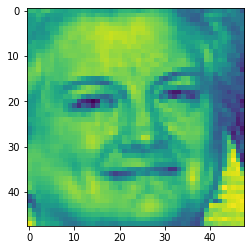

In [16]:
import matplotlib.pyplot as plt
image = plt.imread(os.path.join(current_working_dir, validation_path, happy_path) + '/100.jpg')
plt.imshow(image)

In [24]:
# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()
datagen_test = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(os.path.join(current_working_dir, train_path),
                                                    target_size=(image_shape,image_shape),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(os.path.join(current_working_dir, validation_path),
                                                    target_size=(image_shape,image_shape),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

test_generator = datagen_test.flow_from_directory(os.path.join(current_working_dir, test_path),
                                                    target_size=(image_shape,image_shape),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 2450 images belonging to 7 classes.
Found 609 images belonging to 7 classes.
Found 783 images belonging to 7 classes.


In [26]:
# Initialising the CNN
model4 = Sequential()

# 1 - Convolution
model4.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

# 2nd Convolution layer
model4.add(Conv2D(128,(5,5), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

# 3rd Convolution layer
model4.add(Conv2D(256,(3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

# 4th Convolution layer
model4.add(Conv2D(512,(3,3), padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.25))

# Flattening
model4.add(Flatten())

# Fully connected layer 1st layer
model4.add(Dense(256))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.25))

# Fully connected layer 2nd layer
model4.add(Dense(512))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(Dropout(0.25))

model4.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.001)
model4.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 40

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history4 = model4.fit_generator(generator=train_generator,
                      steps_per_epoch=train_generator.n//train_generator.batch_size,
                      epochs=epochs,
                      validation_data = validation_generator,
                      validation_steps = validation_generator.n//validation_generator.batch_size,
                      callbacks=callbacks_list
                     )

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 2.2732 - accuracy: 0.1593

19/19 [==============================] - 77s 4s/step - loss: 2.2732 - accuracy: 0.1593 - val_loss: 27.0736 - val_accuracy: 0.1504
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 2.0648 - accuracy: 0.2175

19/19 [==============================] - 79s 4s/step - loss: 2.0648 - accuracy: 0.2175 - val_loss: 20.3175 - val_accuracy: 0.1699
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 2.0256 - accuracy: 0.2261

19/19 [==============================] - 75s 4s/step - loss: 2.0256 - accuracy: 0.2261 - val_loss: 14.5205 - val_accuracy: 0.1699
Epoch 4/40
19/19 [==============================] - ETA: 0s - loss: 1.9404 - accuracy: 0.2580

19/19 [==============================] - 77s 4s/step - loss: 1.9404 - accuracy: 0.2580 - val_loss: 10.9236 - val_accuracy: 0.1699
Epoch 5/40
19/19 [==============================] - ETA: 0s - loss: 1.8633 - accuracy: 0.2870

19/19 [==============================] - 78s 4s/step - loss: 1.8633 - accuracy: 0.2870 - val_loss: 3.6125 - val_accuracy: 0.1504
Epoch 6/40
19/19 [==============================] - ETA: 0s - loss: 1.8025 - accuracy: 0.3002

19/19 [==============================] - 77s 4s/step - loss: 1.8025 - accuracy: 0.3002 - val_loss: 2.6401 - val_accuracy: 0.1816
Epoch 7/40
19/19 [==============================] - ETA: 0s - loss: 1.7424 - accuracy: 0.3342

19/19 [==============================] - 78s 4s/step - loss: 1.7424 - accuracy: 0.3342 - val_loss: 1.8165 - val_accuracy: 0.2949
Epoch 8/40
19/19 [==============================] - ETA: 0s - loss: 1.6909 - accuracy: 0.3557

19/19 [==============================] - 76s 4s/step - loss: 1.6909 - accuracy: 0.3557 - val_loss: 1.7837 - val_accuracy: 0.3105
Epoch 9/40
19/19 [==============================] - ETA: 0s - loss: 1.6415 - accuracy: 0.3859

19/19 [==============================] - 78s 4s/step - loss: 1.6415 - accuracy: 0.3859 - val_loss: 1.6778 - val_accuracy: 0.3398
Epoch 10/40
19/19 [==============================] - ETA: 0s - loss: 1.5885 - accuracy: 0.3962

19/19 [==============================] - 75s 4s/step - loss: 1.5885 - accuracy: 0.3962 - val_loss: 1.5271 - val_accuracy: 0.4082
Epoch 11/40
19/19 [==============================] - ETA: 0s - loss: 1.5439 - accuracy: 0.4251

19/19 [==============================] - 78s 4s/step - loss: 1.5439 - accuracy: 0.4251 - val_loss: 1.4713 - val_accuracy: 0.4199
Epoch 12/40
19/19 [==============================] - ETA: 0s - loss: 1.4974 - accuracy: 0.4380

19/19 [==============================] - 75s 4s/step - loss: 1.4974 - accuracy: 0.4380 - val_loss: 1.5167 - val_accuracy: 0.4297
Epoch 13/40
19/19 [==============================] - ETA: 0s - loss: 1.3982 - accuracy: 0.4746

19/19 [==============================] - 77s 4s/step - loss: 1.3982 - accuracy: 0.4746 - val_loss: 1.6096 - val_accuracy: 0.3906
Epoch 14/40
19/19 [==============================] - ETA: 0s - loss: 1.3004 - accuracy: 0.5132

19/19 [==============================] - 79s 4s/step - loss: 1.3004 - accuracy: 0.5132 - val_loss: 1.5563 - val_accuracy: 0.4395
Epoch 15/40
19/19 [==============================] - ETA: 0s - loss: 1.2589 - accuracy: 0.5263

19/19 [==============================] - 77s 4s/step - loss: 1.2589 - accuracy: 0.5263 - val_loss: 1.4685 - val_accuracy: 0.4668
Epoch 16/40
19/19 [==============================] - ETA: 0s - loss: 1.2010 - accuracy: 0.5457

19/19 [==============================] - 75s 4s/step - loss: 1.2010 - accuracy: 0.5457 - val_loss: 1.3466 - val_accuracy: 0.5156
Epoch 17/40
19/19 [==============================] - ETA: 0s - loss: 1.1667 - accuracy: 0.5672

19/19 [==============================] - 78s 4s/step - loss: 1.1667 - accuracy: 0.5672 - val_loss: 1.4888 - val_accuracy: 0.4473
Epoch 18/40
19/19 [==============================] - ETA: 0s - loss: 1.1030 - accuracy: 0.5930

19/19 [==============================] - 75s 4s/step - loss: 1.1030 - accuracy: 0.5930 - val_loss: 1.1525 - val_accuracy: 0.5664
Epoch 19/40
19/19 [==============================] - ETA: 0s - loss: 1.0809 - accuracy: 0.5891

19/19 [==============================] - 77s 4s/step - loss: 1.0809 - accuracy: 0.5891 - val_loss: 1.2327 - val_accuracy: 0.5664
Epoch 20/40
19/19 [==============================] - ETA: 0s - loss: 0.9995 - accuracy: 0.6305

19/19 [==============================] - 75s 4s/step - loss: 0.9995 - accuracy: 0.6305 - val_loss: 1.0251 - val_accuracy: 0.6309
Epoch 21/40
19/19 [==============================] - ETA: 0s - loss: 0.9414 - accuracy: 0.6443

19/19 [==============================] - 77s 4s/step - loss: 0.9414 - accuracy: 0.6443 - val_loss: 1.3899 - val_accuracy: 0.4922
Epoch 22/40
19/19 [==============================] - ETA: 0s - loss: 0.9231 - accuracy: 0.6568

19/19 [==============================] - 76s 4s/step - loss: 0.9231 - accuracy: 0.6568 - val_loss: 1.1629 - val_accuracy: 0.5410
Epoch 23/40
19/19 [==============================] - ETA: 0s - loss: 0.8608 - accuracy: 0.6912

19/19 [==============================] - 77s 4s/step - loss: 0.8608 - accuracy: 0.6912 - val_loss: 0.6209 - val_accuracy: 0.8184
Epoch 24/40
19/19 [==============================] - ETA: 0s - loss: 0.7683 - accuracy: 0.7093

19/19 [==============================] - 78s 4s/step - loss: 0.7683 - accuracy: 0.7093 - val_loss: 0.7996 - val_accuracy: 0.6914
Epoch 25/40
19/19 [==============================] - ETA: 0s - loss: 0.7081 - accuracy: 0.7416

19/19 [==============================] - 77s 4s/step - loss: 0.7081 - accuracy: 0.7416 - val_loss: 0.6560 - val_accuracy: 0.7441
Epoch 26/40
19/19 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.7730

19/19 [==============================] - 75s 4s/step - loss: 0.6333 - accuracy: 0.7730 - val_loss: 0.9024 - val_accuracy: 0.6680
Epoch 27/40
19/19 [==============================] - ETA: 0s - loss: 0.6198 - accuracy: 0.7812

19/19 [==============================] - 77s 4s/step - loss: 0.6198 - accuracy: 0.7812 - val_loss: 0.4291 - val_accuracy: 0.8418
Epoch 28/40
19/19 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.7756

19/19 [==============================] - 75s 4s/step - loss: 0.6206 - accuracy: 0.7756 - val_loss: 0.3933 - val_accuracy: 0.8594
Epoch 29/40
19/19 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.7855

19/19 [==============================] - 78s 4s/step - loss: 0.5781 - accuracy: 0.7855 - val_loss: 0.5146 - val_accuracy: 0.7891
Epoch 30/40
19/19 [==============================] - ETA: 0s - loss: 0.5345 - accuracy: 0.8049

19/19 [==============================] - 76s 4s/step - loss: 0.5345 - accuracy: 0.8049 - val_loss: 0.5043 - val_accuracy: 0.8223
Epoch 31/40
19/19 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.8080

19/19 [==============================] - 82s 4s/step - loss: 0.5287 - accuracy: 0.8080 - val_loss: 0.9592 - val_accuracy: 0.6562
Epoch 32/40
19/19 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.8333

19/19 [==============================] - 76s 4s/step - loss: 0.4804 - accuracy: 0.8333 - val_loss: 0.4072 - val_accuracy: 0.8535
Epoch 33/40
19/19 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8407

19/19 [==============================] - 77s 4s/step - loss: 0.4656 - accuracy: 0.8407 - val_loss: 0.3924 - val_accuracy: 0.8633
Epoch 34/40
19/19 [==============================] - ETA: 0s - loss: 0.4422 - accuracy: 0.8480

19/19 [==============================] - 75s 4s/step - loss: 0.4422 - accuracy: 0.8480 - val_loss: 0.1971 - val_accuracy: 0.9434
Epoch 35/40
19/19 [==============================] - ETA: 0s - loss: 0.4127 - accuracy: 0.8536

19/19 [==============================] - 77s 4s/step - loss: 0.4127 - accuracy: 0.8536 - val_loss: 0.4009 - val_accuracy: 0.8633
Epoch 36/40
19/19 [==============================] - ETA: 0s - loss: 0.4151 - accuracy: 0.8484

19/19 [==============================] - 76s 4s/step - loss: 0.4151 - accuracy: 0.8484 - val_loss: 0.1777 - val_accuracy: 0.9551
Epoch 37/40
19/19 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8751

19/19 [==============================] - 77s 4s/step - loss: 0.3660 - accuracy: 0.8751 - val_loss: 0.1349 - val_accuracy: 0.9688
Epoch 38/40
19/19 [==============================] - ETA: 0s - loss: 0.3274 - accuracy: 0.8837

19/19 [==============================] - 75s 4s/step - loss: 0.3274 - accuracy: 0.8837 - val_loss: 0.5822 - val_accuracy: 0.8027
Epoch 39/40
19/19 [==============================] - ETA: 0s - loss: 0.3099 - accuracy: 0.8910

19/19 [==============================] - 78s 4s/step - loss: 0.3099 - accuracy: 0.8910 - val_loss: 0.0879 - val_accuracy: 0.9824
Epoch 40/40
19/19 [==============================] - ETA: 0s - loss: 0.2896 - accuracy: 0.9005

19/19 [==============================] - 76s 4s/step - loss: 0.2896 - accuracy: 0.9005 - val_loss: 0.2455 - val_accuracy: 0.9023


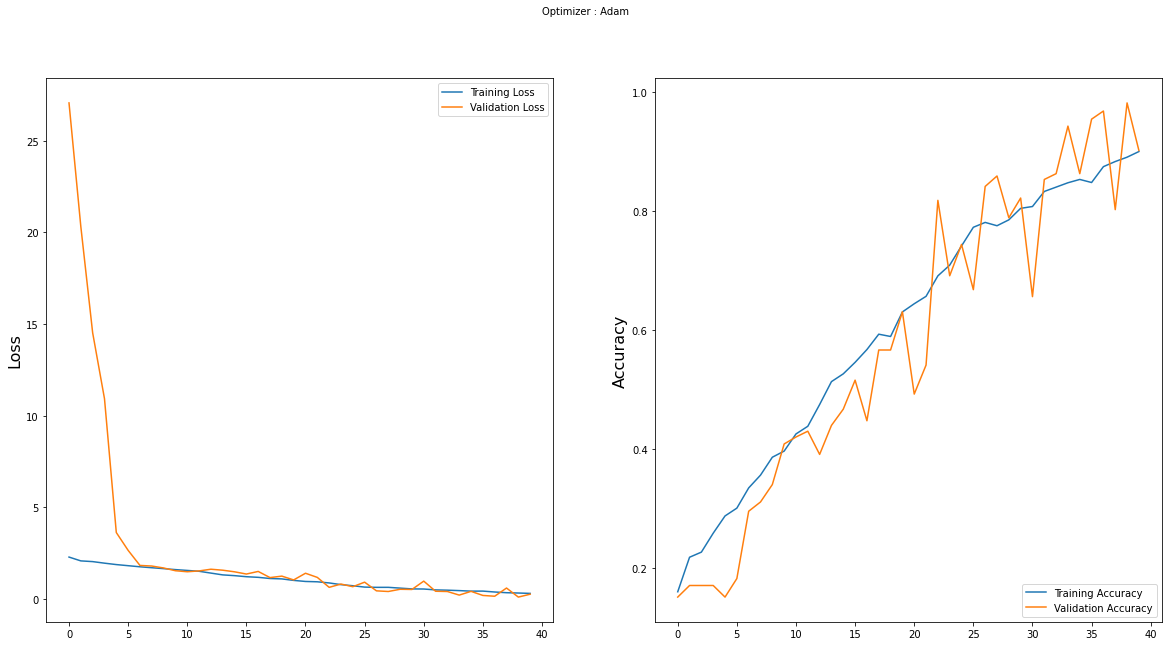

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [31]:
predictions_4 = model4.predict(x=test_generator, steps=len(test_generator), verbose=0)
print(model4.evaluate(x=test_generator))

7/7 [==============================] - 6s 817ms/step - loss: 2.4762 - accuracy: 0.4266
[2.4762353897094727, 0.426564484834671]


In [32]:
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(y_true=test_generator.classes, y_pred=np.argmax(predictions_4, axis=-1))
cm4

array([[21, 12,  6,  6, 42, 20,  5],
       [ 1, 84,  1,  1, 12, 10,  2],
       [ 9, 19,  5,  8, 38, 21, 12],
       [10,  3,  0, 59, 20, 12,  8],
       [10,  7,  0,  8, 61, 21,  5],
       [ 4,  8,  2,  5, 48, 41,  4],
       [ 3,  7,  2,  5, 28,  4, 63]])